## Simplify the model with p-values

The null hypothesis is the parameter value is zero. If the p-value is larger than a given confidence level, the null hypothesis cannot be rejected, meaning the parameter is not statistically significant, hence not necessary.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9,8]
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model
from pandas_datareader import DataReader
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

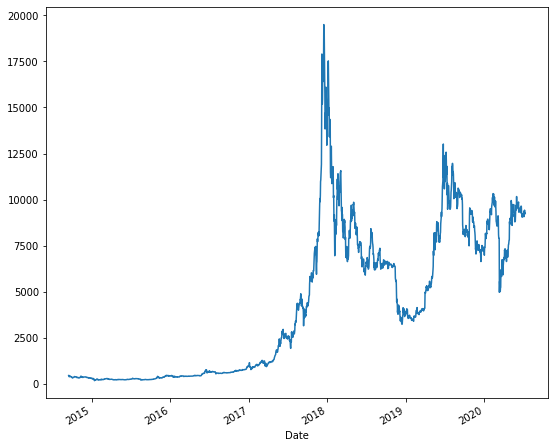

In [2]:
start = datetime(2010,1,1)
end = datetime(2020,7,10)

bitcoin = DataReader('BTC-USD', 'yahoo',start, end)
bitcoin.drop(columns=['High','Low','Open','Volume','Adj Close'], inplace=True)
bitcoin['Return'] = 100*(bitcoin['Close'].pct_change())
bitcoin['Close'].plot()
plt.show()

In [3]:
# Specify model assumptions
gm = arch_model(bitcoin['Return'].dropna(), p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
gm_result = gm.fit(disp = 'off')

In [4]:
# Print model fitting summary
print(gm_result.summary())

# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -5338.80
Distribution:      Standardized Student's t   AIC:                           10689.6
Method:                  Maximum Likelihood   BIC:                           10723.6
                                              No. Observations:                 2124
Date:                      Mon, Jul 13 2020   Df Residuals:                     2118
Time:                              10:26:04   Df Model:                            6
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

According to the p-values, the parameters gamma is not statistically significant given a confidence level of 5%, so the null hypnosis claiming the parameter value is zero cannot be rejected. In this case, an asymmetric GARCH model seems to be an overkill.

## Simplify the model with t-statistics

Besides p-values, t-statistics can also help decide the necessity of model parameters.

The t-statistic is computed as the estimated parameter value subtracted by its expected mean (zero in this case), and divided by its standard error. The absolute value of the t-statistic is a distance measure, that tells you how many standard errors the estimated parameter is away from 0. As a rule of thumb, if the t-statistic is larger than 2, you can reject the null hypothesis.

In [5]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'std-err': gm_result.std_err, 
                             't-value': gm_result.tvalues})

# Verify t-statistic by manual calculation
calculated_t = para_summary['parameter']/para_summary['std-err']

# Print calculated t-value
print(calculated_t)

# Print parameter stats
print(para_summary)

mu            3.822041
omega         3.037730
alpha[1]      6.623160
gamma[1]      1.426943
beta[1]     151.824183
nu           16.218004
dtype: float64
          parameter   std-err     t-value
mu         0.138501  0.036238    3.822041
omega      0.111566  0.036727    3.037730
alpha[1]   0.314763  0.047525    6.623160
gamma[1]   0.026203  0.018363    1.426943
beta[1]    0.987203  0.006502  151.824183
nu         2.581130  0.159152   16.218004


The t-statistics are in agreement with p-values, pointing out that the gamma parameter is not statistically significant and should be left out of the model.

## ACF plot

If a GARCH model is doing a good job, the standardized residuals should not exhibit autocorrelations. In this exercise, you will practice using an ACF plot to detect autocorrelations in the data.

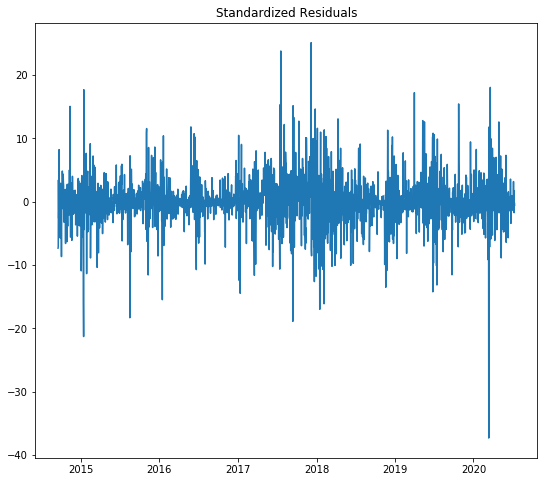

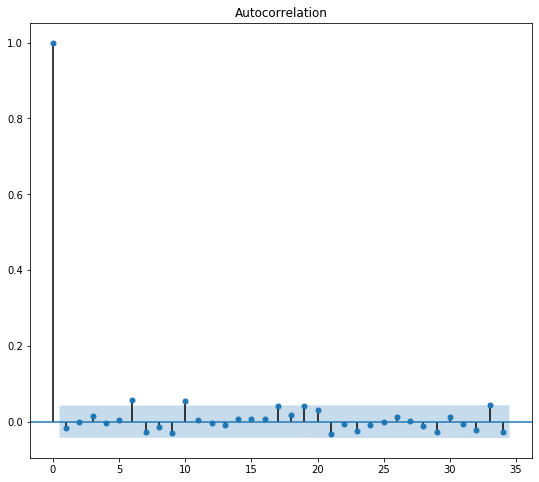

In [6]:
std_resid = gm_result.resid

# Plot the standardized residuals
plt.plot(std_resid)
plt.title('Standardized Residuals')
plt.show()

# Generate ACF plot of the standardized residuals
plot_acf(std_resid, alpha = 0.05)
plt.show()

ACF plot shows the majority of the data points are within the confidence interval, so the model is doing a decent job.

## Ljung-Box test

Another powerful tool to check autocorrelations in the data is the Ljung-Box test.

The null hypothesis of Ljung-Box test is: the data is independently distributed. If the p-value is larger than the specified significance level, the null hypothesis cannot be rejected. In other words, there is no clear sign of autocorrelations and the model is valid.

In [7]:
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(std_resid , lags = 10)

# Print the p-values
print('P-values are: ', lb_test[1])

P-values are:  [0.43627277 0.73809022 0.77767867 0.8883076  0.94670642 0.23242298
 0.2144875  0.26808755 0.22866071 0.05512081]


All the p-values are larger than 5% so the null hypothesis cannot be rejected. In other words, no autocorrelations detected and the model is doing a decent job.

## Pick a winner based on log-likelihood

GARCH models use the maximum likelihood method to estimate parameters. In general, the bigger the log-likelihood, the better the model since it implies a bigger probability of having observed the data we got.

In [8]:
# Specify a GARCH(1,1) model
normal_gm = arch_model(bitcoin['Return'].dropna(), p = 1, q = 1, 
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

# Fit the model
normal_result = normal_gm.fit(disp = 'off')

# Specify a GARCH(1,1) model
skewt_gm = arch_model(bitcoin['Return'].dropna(), p = 1, q = 1, 
                      mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

In [9]:
# Print normal GARCH model summary
print(normal_result.summary())
# Print skewed GARCH model summary
print(skewt_result.summary())

# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', normal_result.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -5686.84
Distribution:                  Normal   AIC:                           11381.7
Method:            Maximum Likelihood   BIC:                           11404.3
                                        No. Observations:                 2124
Date:                Mon, Jul 13 2020   Df Residuals:                     2120
Time:                        10:26:05   Df Model:                            4
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1964  6.672e-02      2.944  3.238e-03 [6.566e-0

The GARCH model with skewed Student's t-distribution assumption has a higher log-likelihood, hence is relatively better.

## Pick a winner based on AIC/BIC

Information criteria intend to measure the trade-off between goodness of fit and model complexity. AIC and BIC are two commonly used information criteria for model selection. They both impose penalties on model with more parameters, or more complex models. The lower the AIC or BIC, the better the model.

In [10]:
# Specify model assumptions
gjr_gm = arch_model(bitcoin['Return'].dropna(), p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Specify model assumptions
egarch_gm = arch_model(bitcoin['Return'].dropna(), p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

In [11]:
# Print the AIC GJR-GARCH
print('AIC of GJR-GARCH model :', gjrgm_result.aic)
# Print the AIC of EGARCH
print('AIC of EGARCH model :', egarch_result.aic)

# Print the BIC GJR-GARCH
print('BIC of GJR-GARCH model :', gjrgm_result.bic)
# Print the BIC of EGARCH
print('BIC of EGARCH model :', egarch_result.bic)

AIC of GJR-GARCH model : 10727.465944085454
AIC of EGARCH model : 10689.608092225393
BIC of GJR-GARCH model : 10761.432282379625
BIC of EGARCH model : 10723.574430519564


Both AIC and BIC of the EGARCH model are lower, hence EGARCH is relatively better.

In [12]:
start_loc = 1031
end_loc = 1251
forecasts = {}

for i in range(30):
    # Specify fixed rolling window size for model fitting
    gm_result = gm.fit(first_obs = start_loc, 
                             last_obs = i + end_loc, update_freq = 5, disp = 'off')
    # Conduct 1-period variance forecast and save the result
    temp_result = gm_result.forecast(horizon = 1).variance
    fcast = temp_result.iloc[i + end_loc]
    forecasts[fcast.name] = fcast
# Save all forecast to a dataframe    
forecast_var = pd.DataFrame(forecasts).T

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [14]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(mae))
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print('Mean Squared Error (MSE): {:.3g}'.format(mse))
    return mae, mse

In [15]:
# Backtest model with MAE, MSE
evaluate(bitcoin['Return'].loc['2018-2-20':'2018-3-21'], forecast_var)

Mean Absolute Error (MAE): 41.4
Mean Squared Error (MSE): 1.86e+03


(41.365167558057216, 1858.0661859957986)